# Joining catalogs

In this tutorial, we will demonstrate how to perform a JOIN on two catalogs.

Note that this is different from a crossmatch, because the two catalogs share unique identifiers and we can match those values directly. This will still use the spatial properties to perform the JOIN on a per-partition basis.

## Introduction

Gaia is a space telescope that provides excellent astrometric precision, and so is used for determining parallax distances to nearby stars. The parallax distances are not available in all data products, however.

In this notebook, we join Gaia with Gaia Early Data Release 3 (EDR3) and compute the ratio between the distances given by their `parallax` and `r_med_geo` columns, respectively.

In [1]:
import lsdb
from lsdb import ConeSearch

## 1. Load the catalogs

First we load Gaia with its objects `source_id`, their positions and `parallax` columns.

In [2]:
gaia = lsdb.open_catalog(
    "https://data.lsdb.io/hats/gaia_dr3/gaia",
    margin_cache="https://data.lsdb.io/hats/gaia_dr3/gaia_10arcs",
    columns=["source_id", "ra", "dec", "parallax"],
    search_filter=ConeSearch(ra=0, dec=0, radius_arcsec=10 * 3600),
)
gaia

,source_id,ra,dec,parallax
npartitions=4,,,,
"Order: 2, Pixel: 67",int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow]
"Order: 2, Pixel: 70",...,...,...,...
"Order: 2, Pixel: 73",...,...,...,...
"Order: 2, Pixel: 76",...,...,...,...


We will do the same with Gaia EDR3 but the distance column we will use is called `r_med_geo`, the median of the geometric distance estimate.

In [3]:
gaia_edr3 = lsdb.open_catalog(
    "https://data.lsdb.io/hats/gaia_edr3_distances",
    margin_cache="https://data.lsdb.io/hats/gaia_edr3_distances/gaia_edr3_distances_10arcs",
    columns=["source_id", "ra", "dec", "r_med_geo"],
    search_filter=ConeSearch(ra=0, dec=0, radius_arcsec=10 * 3600),
)
gaia_edr3

,source_id,ra,dec,r_med_geo
npartitions=4,,,,
"Order: 2, Pixel: 67",int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow]
"Order: 2, Pixel: 70",...,...,...,...
"Order: 2, Pixel: 73",...,...,...,...
"Order: 2, Pixel: 76",...,...,...,...


## 2. Join Operation

We are now able to join both catalogs on the `source_id` column, as follows:

In [4]:
joined = gaia.join(gaia_edr3, left_on="source_id", right_on="source_id")
joined

/astro/users/olynn/lsdb/src/lsdb/catalog/catalog.py:840: FutureWarning: The default suffix behavior will change from applying suffixes to all columns to only applying suffixes to overlapping columns in a future release.To maintain the current behavior, explicitly set `suffix_method='all_columns'`. To change to the new behavior, set `suffix_method='overlapping_columns'`.
  warnings.warn(


,source_id_gaia,ra_gaia,dec_gaia,parallax_gaia,source_id_gaia_edr3_distances,ra_gaia_edr3_distances,dec_gaia_edr3_distances,r_med_geo_gaia_edr3_distances
npartitions=4,,,,,,,,
"Order: 2, Pixel: 67",int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow]
"Order: 2, Pixel: 70",...,...,...,...,...,...,...,...
"Order: 2, Pixel: 73",...,...,...,...,...,...,...,...
"Order: 2, Pixel: 76",...,...,...,...,...,...,...,...


## 3. Joint analysis

Let's calculate a histogram with the ratio in catalog distances.

In [5]:
results = (1e3 / joined["parallax_gaia"]) / joined["r_med_geo_gaia_edr3_distances"]
ratios = results.compute().to_numpy()
ratios

array([  1.04369179,   0.99821673,   0.96884423, ...,   1.03218566,
       147.42381857,   1.41197562], shape=(825678,))

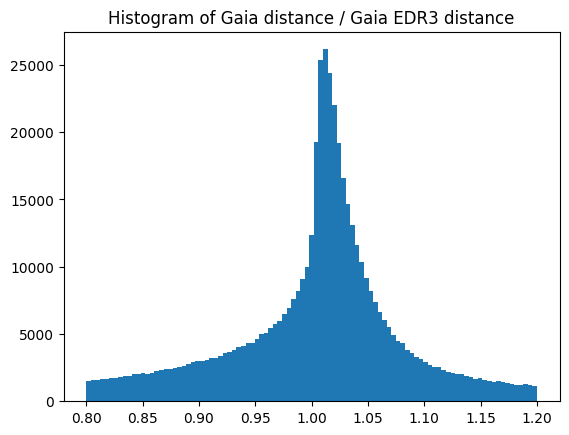

In [6]:
import numpy as np
import matplotlib.pyplot as plt

plt.hist(ratios, bins=np.linspace(0.8, 1.2, 100))
plt.title("Histogram of Gaia distance / Gaia EDR3 distance")
plt.show()

## About

**Authors**: Sandro Campos

**Last updated on**: Oct 27, 2025

If you use `lsdb` for published research, please cite following [instructions](https://docs.lsdb.io/en/stable/citation.html).